<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/2022notebooks/2022_0104Masked_Language_Modeling_With_BERT_ja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- date: 2022_0104
- source: https://towardsdatascience.com/masked-language-modelling-with-bert-7d49793e5d2c
- author: James Briggs
- date_origin: May 19, 2021

# Masked-Language Modeling With BERT

みんなのお気に入りの変換ツールである BERT は ，Google が学習するのに約 7,000 ドルかかりました [1]。
しかし，私たちは，同じモデルを使用するために数行のコードを書くだけで，すべて無料で利用できます。
<!-- BERT, everyone’s favorite transformer costs Google ~\$7K to train [1] (and who knows how much in R&D costs). 
From there, we write a couple of lines of code to use the same model — all for free. -->

BERT は，マスクド・言語モデル (MLM) と次文予測 (NSP) という  2  つの独自の学習アプ ローチにより，NLP  において比類のない成功を収めています。
<!-- BERT has enjoyed unparalleled success in NLP thanks to two unique training approaches, masked-language modeling (MLM), and next sentence prediction (NSP). -->

多くの場合，事前に学習済  BERT モデルをそのまま使用して，自分の言語課題にうまく適用することができるかもしれません。
<!-- In many cases, we might be able to take the pre-trained BERT model out-of-the-box and apply it successfully to our own language tasks.-->

しかし，多くの場合，モデルを微調整する必要があります。
<!-- But often, we might need to fine-tune the model. -->

In [ ]:
from IPython.display import YouTubeVideo, display
tube_id = 'q9NS5WpfkrU'
display(YouTubeVideo(tube_id, width=600, height=400))

MLM でさらに訓練を重ねることで，より具体的な領域での言語の特殊な使用方法をよりよく理解できるように BERT を微調整することができます。

すぐに使える BERT - 汎用的な使用に最適。
MLM で微調整された BERT - ドメイン固有の使用に最適。

この記事では MLM とは何か，どのように機能するのか，そして MLM を使ってどのようにモデルを改善できるのかについて，詳しく説明します。
<!-- Further training with MLM allows us to fine-tune BERT to better understand the particular use of language in a more specific domain.

Out-of-the-box BERT — great for general purpose use. Fine-tuned with MLM BERT — great for domain-specific use.

In this article, we’ll go into depth about what MLM is, how it works, and how we can improve our models with it.
-->

# マスク化言語モデル MLM
<!-- # Masked-Language Modeling -->

MLM は BERT に文を与え，BERT 内部の重みを最適化して，相手側に同じ文を出力することで構成されています。
<!--MLM consists of giving BERT a sentence and optimizing the weights inside BERT to output the same sentence on the other side.-->

つまり，文を入力し，BERT が同じ文を出力するように要求します。
<!-- So we input a sentence and ask that BERT outputs the same sentence. -->

しかし，実際に BERT にその入力文を与える前に，いくつかのトークンを必要とします。
<!-- However, before we actually give BERT that input sentence — we mask a few tokens. -->

<center>
<img src="https://miro.medium.com/max/1400/1*phTLnQ8itb3ZX5_h9BWjWw.png" width="600px"><br/>
この画像では，トークン を BERT に渡す前に，リンカーン・トークンを [MASK] に置き換えてマスクしています。
    <!-- In this image, before passing our tokens into BERT — we have masked the lincoln token, replacing it with [MASK]. -->
</center>

つまり，実際には不完全な文章を入力して，BERT に完成させるように依頼しているのです。
<!-- So we’re actually inputting an incomplete sentence and asking BERT to complete it for us. -->

## 間隙を埋める <!--Fill In The Gaps-->

これはどのような効果があるのでしょうか？
それは、多くの人が学校で与えられた問題のようなものです。つまり、文章が与えられたら、その穴を埋めなければなりません。
<!-- What is the effect of this? 
Well, it’s like those questions many of us were given in school — where, given a sentence, we had to fill in the gaps. -->


`秋 に は ， ___ が 木 から 落ちる 。`
<!-- `In Autumn the ______ fall from the trees.`-->

答えがわかりますか？
ほとんど、あなたは分かっているでしょう。
それは，文脈を考慮したからです。
<!-- Do you know the answer? 
Most likely you do, and you do because you have considered the context of the sentence.-->

「落ちる」 と 「木」 という単語が出てきましたが，足りない単語は木から落ちるものだということがわかります。
<!-- We see the words fall and trees — we know that the missing word is something that falls from trees. -->

どんぐり，枝，葉など，木から落ちるものはたくさんありますが，秋という別の条件があるので，秋に木から落ちる可能性が最も高いのは葉だということで，検索対象が絞られます。
<!-- A lot of things fall from trees, acorns, branches, leaves — but we have another condition, in Autumn — that narrows down our search, the most probable thing to fall from a tree in Autumn are leaves. -->

人間として，私たちは一般的な世界の知識と言語的な理解を組み合わせて，その結論を導き出します。
BERT の場合，この推測は，たくさんの本を読み，言語パターンを非常によく学んでいることから得られます。
<!-- As humans, we use a mix of general world knowledge, and linguistic understanding to come to that conclusion. 
For BERT, this guess will come from reading a lot — and learning linguistic patterns incredibly well. -->

BERT は，秋，木，葉が何であるかを知らないかもしれませんが，言語パターンとこれらの単語の文脈から，答えが葉である可能性が最も高いことを知っています。
<!-- BERT may not know what Autumn, trees, and leaves are — but it does know that given linguistic patterns, and the context of these words, the answer is most likely to be leaves. -->

この処理の結果，BERT にとっては，使用されている言語のスタイルの理解度が向上します。
<!-- The outcome of this process — for BERT — is an improved comprehension of the style of language being used. -->

## 実際の処理 <!--The Process-->

MLM が何をしているかは理解できましたが，実際にはどのように機能するのでしょうか？
コード上で必要となる論理的なステップは何でしょうか？
<!-- So we understand what MLM is doing, but how does this actually work? 
What are the logical steps that we’ll need to follow in code? -->


1.  テキストをトークン化します。
通常の変換機と同じように，まずテキストのトークン化を行います。
トークン化からは 3 つの異なるテンソルが得られます。

<!-- 1. We tokenize our text. Just like we usually would with transformers, we begin with text tokenization.
From tokenization we will receive three different tensors:
-->

* input_ids
* token_type_ids
* attention_mask

MLM には token_type_ids は必要ないし，この例では attention_mask はそれほど重要ではありません。
<!-- We don’t need token_type_ids for MLM — and in this example attention_mask is not so important.-->

我々にとっては input_ids テンソルが最も重要です。
ここには，トークン化されたテキスト表現があり，これを今後修正していくことになるでしょう。
<!--For us, the input_ids tensor is most important. Here, we will have a tokenized representation of our text — which is what we will be modifying moving forwards.-->

2. `labels tensor` を作成する。
ここではモデルを訓練しているので，損失を計算して最適化するためのラベルテンソルが必要です。
`labels tensor` は単純に `input_ids` なので，これをコピーするだけです。
<!-- 2. Create a labels tensor. We’re training our model here, so we need a labels tensor to calculate loss against — and optimize towards.
The labels tensor is simply input_ids — so all we need to do is make a copy.-->

3. `input_ids` のトークンをマスクする。
label 用の `input_ids` のコピーを作成したので，先にトークンのランダムな選択をマスクすることができます。
<!-- 3. Mask tokens in input_ids. Now that we’ve created a copy of input_ids for labels, we can go ahead and mask a random selection of tokens. -->

BERT 論文では，モデルの事前訓練中に，いくつかの追加ルールを用いて，各トークンを 15％ の確率でマスク化していますが，ここではこれを簡略化して，各単語を 15％ の確率でマスク化することにします。
<!-- The BERT paper uses a 15% probability of masking each token during model pre-training, with a few additional rules — we’ll use a simplified version of this and assign a 15% probability of each word being masked. -->

4. 損失を計算します。
`input_ids` と `labels` のテンソルを BERT モデルで処理し，両者の間の損失を計算します。
この損失を用いて，BERT による必要な勾配変化を計算し，モデルの重みを最適化します。
<!--4. Calculate loss. We process the input_ids and labels tensors through our BERT model and calculate the loss between them both.
Using this loss, we calculate the required gradient changes with BERT — and optimize our model weights. -->

<center>
<img src="https://miro.medium.com/max/1400/1*0KvOrY6rY055m9oq36HRkg.png" width="600px"><br/>
<div style="text-align:left; width:40%; background-color:cornsilk" width="400px">
512 個のトークンはすべて，モデルの語彙サイズに等しいベクトル長を持ちます。
最終的な出力埋め込みベクトルであるロジット(確率比) を生成します。
予測されたトークン ID は，lソフトマックスと argmax 変換を用いて，このロジットから抽出されます。
<!-- All 512 tokens produce a final output embedding — the logits — which has a vector length equal to the model vocab size. 
The predicted token_id is extracted from this logit using a softmax and argmax transformation. -->
</div>    
</center>    

損失は，各出力「トークン」の出力確率分布と，真のワンホット符号化ラベルとの差として計算されます。
<!-- The loss is calculated as the difference between the output probability distributions for each output ‘token’, and the true one-hot encoded labels.
-->

# マスク化言語モデル MLM のコード MLM In Code

さて，それはすごいことですが，MLM をコードで実証するにはどうすればよいでしょうか？
<!-- Okay, that’s all great, but how can we demonstrate MLM in code? -->

HuggingFace のトランスフォーマーと PyTorch そして bert-base-uncased モデルを使用します。
では，まず全てをインポートして初期化しましょう。
<!-- We’ll be using HuggingFace’s transformers and PyTorch, alongside the bert-base-uncased model. So, let’s import and initialize everything first:
-->

In [2]:
import platform
isColab = True if platform.system() == 'Linux' else False
if isColab:
    !pip install transformers > /dev/null 2>&1 

In [3]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

text = ("After Abraham Lincoln won the November 1860 presidential "
        "election on an anti-slavery platform, an initial seven "
        "slave states declared their secession from the country "
        "to form the Confederacy. War broke out in April 1861 "
        "when secessionist forces attacked Fort Sumter in South "
        "Carolina, just over a month after Lincoln's "
        "inauguration.")

それでは，それぞれの論理的なステップへと進んでいきます。
<!-- And now we move into each one of our logical steps, starting with:-->

<font size="+2">1.  **トークン化**</font> - トークン化は簡単です。
すでに BertTokenizer を初期化しましたので，あとは入力テキストをトークン化するだけです。
<!--1. Tokenization — tokenization is simple, we’ve already initialized a BertTokenizer, all we do now is tokenize our input text. -->

In [ ]:
inputs = tokenizer(text, return_tensors='pt')
print(inputs.keys())
print(inputs)

ここでは，埋め草(パディング) や 切断(トランケーション)については気にしません。
`token_type_ids` と `attention_mask` は特に気にする必要はありませんが `input_ids` は気になります。
<!-- We won’t worry about padding/truncation for now. 
What we should be aware of are the three tensors described earlier — token_type_ids and attention_mask don’t need any attention from us — but input_ids does.-->

<font size="+2">2. **ラベル作成**</font> - 次のステップは簡単です。
ここで必要なのは `input_ids` テンソルを新しい labels テンソルにクローンすることです。
これも `inputs` 変数に格納します。
<!--2. Create labels — The next step is easy, all we need to do here is clone our input_ids tensor into a new labels tensor. 
We’ll store this within the inputs variable too. -->

In [ ]:
inputs['labels'] = inputs.input_ids.detach().clone()
print(inputs)

<font size="+2"> 3. **マスキング**</font> -  今度は `input_ids` テンソル内のトークンのランダムな選択をマスキングする必要があります。
<!-- 3. Masking — Now we need to mask a random selection of tokens in our input_ids tensor. -->

トークンを 15% の確率でマスク化するためには `torch.rand` と各値 $<0.15$ という条件を用います。
これらの条件を満たすと，マスキング配列 `mask_arr` が生成されます。
<!-- To create our 15% probability of masking any one token, we can use torch.rand alongside a condition of each value < 0.15. 
Together, these will produce our masking array mask_arr. -->

In [ ]:
# input_idsと同じ次元の浮動小数点数のランダムな配列を作る # create random array of floats in equal dimension to input_ids
rand = torch.rand(inputs.input_ids.shape)
# 乱数配列が0.15 より小さい場合は true を設定 # where the random array is less than 0.15, we set true
mask_arr = rand < 0.15
print(mask_arr)

さて MASK トークンを配置する場所を選ぶために mask_arr を使いますが，CLS トークンや SEP トークンなどの他の特別なトークン (それぞれ 101と 102) の上に MASK トークンを配置したくはありません。
<!-- Now, we use mask_arr to select where to place our MASK tokens — but we don’t want to place a MASK token over other special tokens such as CLS or SEP tokens (101 and 102 respectively).-->

そこで，さらに条件を追加する必要があります。
トークン ID 101 または 102 を含むポジションのチェックです。
<!--So, we need to add an additional condition. A check for positions containing the token ids 101 or 102. -->

In [ ]:
(inputs.input_ids != 101) * (inputs.input_ids != 102)

In [ ]:
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * (inputs.input_ids != 102)
print(mask_arr)

これでマスキング・テンソルができあがりました。
これを適用するために，まず `True` の値が見つかったインデックス位置を抽出し，この選択を使ってこれらのポジションの値を 103 (MASK トークンID) に設定します。
<!-- Now that is our masking tensor, to apply it we will first extract the index positions where we find a True value — then use this selection to set values in these positions to 103 (the MASK token id). -->

In [10]:
# mask_arr から selection を作成 #create selection from mask_arr
selection = torch.flatten((mask_arr[0]).nonzero()).tolist()
print(selection)

[7, 8, 15, 19, 24, 29, 40, 41, 55, 56]


In [11]:
# create selection from mask_arr
selection = torch.flatten((mask_arr[0]).nonzero()).tolist()
selection

[7, 8, 15, 19, 24, 29, 40, 41, 55, 56]

In [ ]:
# selection インデックスを inputs.input_ids へ適用し MASK トークンを追加 ＃apply selection index to inputs.input_ids, adding MASK tokens
inputs.input_ids[0, selection] = 103
print(inputs)

これで，上の `input_ids` テンソルで  103 で表された MASK トークンを見ることができます。
<!-- Now we can see our MASK tokens represented by 103 in the input_ids tensor above.-->

<font size="+2">4. **損失の計算**</font> - ここでの最後のステップは，一般的なモデルの訓練処理と変わりません。
`input_ids` テンソルと `labels` テンソルが `input dictionary` に入っているので，これをモデルに渡してモデルの損失を返すことができます。
<!-- 
4. Calculate Loss — Our final step here no different from the typical model training process.
With both input_ids and labels tensors inside our inputs dictionary, we can pass this to our model and return the model loss. -->

In [13]:
# pass inputs as kwarg to model
outputs = model(**inputs)

In [14]:
# we get two output tensors, loss and logits
print(outputs.keys())

odict_keys(['loss', 'logits'])


In [15]:
print(outputs.loss)

tensor(1.0533, grad_fn=<NllLossBackward0>)


## 訓練 <!-- ## Training -->

さて，ここまで基本的なことを説明してきましたが，モデルを微調整する際にはどのようにすればよいのでしょうか？
訓練には 2 つの方法があります。
(1) これまでに学んだことを全て使って，独自のバージョンの訓練関数を実装する，あるいは
(2) HuggingFace の `Trainer` を使う。
<!-- Cool, we’ve run through all of the essentials — but how would all of this look when fine-tuning a model?
There are two ways, 
(1) we implement our own version of the training function using everything we have learned so far, or 
(2) we use HuggingFace’s Trainer. -->

最適化された使いやすい解法としては，明らかに `Trainer` がお勧めです。
その使い方を紹介しますが，まずは自分で実装してみましょう。
<!-- Trainer is clearly the way to go for an optimized, easy-to-use solution. 
And we’ll take a look at how we can use it — but first, let’s try implementing it ourselves. -->

### 私たちの実装 <!-- ### Our Implementation -->

せっかく学んだのだから，自分で訓練関数を実装してみないともったいないですよね。
<!-- After learning all of this, it would be a waste to not give implementing our own training function a go. -->

<iframe width="665" height="382" src="https://www.youtube.com/embed/R6hcxMMOrPE" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

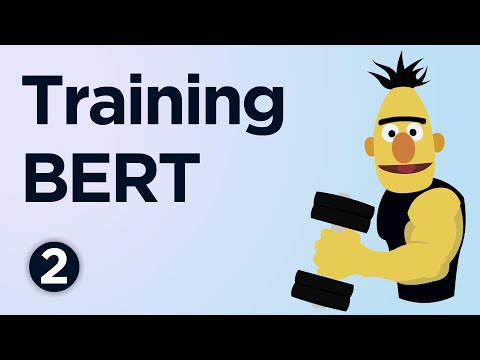

In [21]:
from IPython.display import YouTubeVideo, display
tube_id = 'R6hcxMMOrPE'
display(YouTubeVideo(tube_id, width=600, height=400))

まず，データが必要です。
トークンをランダムにマスキングするだけなので，ほとんどのテキストを使うことができます。
ラベル付きのデータや特別なデータは必要ありません。
<!-- First, we need data. 
Because we’re just randomly masking a selection of tokens — we can use almost any text. We don’t need labeled or special data.-->

ここでは，Marcus Aurelius の Meditations を使用することにします。
ソースは [こちら](http://classics.mit.edu/Antoninus/meditations.html) で，すこし前処理が必要です。([クリアバージョン](https://github.com/jamescalam/transformers/blob/main/data/text/meditations/clean.txt))

<!-- Here, we’ll use Meditations by Marcus Aurelius, sourced from here and preprocessed a little (clean version). -->

まず，テキストデータをインポート/初期化して読み込みます。
<!-- First, we’ll import/initialize and load our text data.  -->

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

In [ ]:
!wget https://raw.githubusercontent.com/jamescalam/transformers/main/data/text/meditations/clean.txt -O clean.txt

In [ ]:
with open('clean.txt', 'r') as fp:
    text = fp.read().split('\n')

print(text[:5])

次に，**トークン化** を行います。
今回は，長さの異なる多くの系列があるため，各系列を切り詰めてパッド化します。
<!-- Then we tokenize — this time we do truncate and pad each sequence — as we have many sequences of different lengths. -->

In [ ]:
inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
print(inputs)

次に `input_id` をクローンして，ラベルテンソルを作成します。
<!-- Now we clone the input_ids to create our labels tensor. -->

In [ ]:
inputs['labels'] = inputs.input_ids.detach().clone()
print(inputs.keys())

次に，マスクのコードですが，今回は 2 つの理由から少し異なります。
<!-- Next is our masking code, which is a little different this time for two reasons:-->

* マスクに PAD トークンを含めてはいけない (CLS や SEP では以前のように)。
* マスクに PAD トークンが含まれてはならない (CLS や SEP ではそうだった)。

<!--* Our mask should not include PAD tokens (as before with CLS and SEP).
* We have many sequences — not just one. -->


In [ ]:
# input_ids テンソルと同じ次元の浮動小数点数のランダムな配列を作成 # create random array of floats with equal dimensions to input_ids tensor
rand = torch.rand(inputs.input_ids.shape)
# mask 配列の作成 # create mask array
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * \
           (inputs.input_ids != 102) * (inputs.input_ids != 0)
print(mask_arr)

そして今度は，それぞれのベクターの中で，各 `True` 値のインデックスを取ります。
<!-- And now we take take the indices of each True value, within each individual vector. -->


In [ ]:
selection = []

for i in range(inputs.input_ids.shape[0]):
    selection.append(
        torch.flatten(mask_arr[i].nonzero()).tolist()
    )
print(selection[:5])

次に，これらのインデックスを `input_ids` の各行に適用し，これらのインデックスの値をそれぞれ 103 として割り当てます。
<!-- Then apply these indices to each respective row in input_ids, assigning each of the values at these indices as 103. -->

In [ ]:
for i in range(inputs.input_ids.shape[0]):
    inputs.input_ids[i, selection[i]] = 103

print(inputs.input_ids)

`mask_arr` テンソルの `True` 値と同じ位置に 103 という値が割り当てられているのがわかります。
<!-- We can see the value 103 assigned in the same position as the True value is found in the mask_arr tensor.-->

これで入力テンソルの準備が整い，学習時にモデルに入力するための設定を始めることができます。
<!-- The inputs tensors are now ready — and we can begin setting them up to be fed into our model during training. -->

学習時には PyTorch の `DataLoader` を使ってデータを読み込みます。
これを使うには，データを PyTorch の `Dataset` オブジェクトにフォーマットする必要があります。
<!-- During training, we’ll be using a PyTorch DataLoader to load our data. To use this, we’ll need to format our data into a PyTorch Dataset object. -->

In [24]:
class MeditationsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

`MeditationsDataset` クラスを使って，データを初期化します。
<!-- Initialize our data using the MeditationsDataset class. -->

In [25]:
dataset = MeditationsDataset(inputs)

そして `dataloader` を初期化します。
`dataloader` は，訓練時にモデルにデータを読み込むために使用します。
<!-- And initialize the dataloader, which we'll be using to load our data into the model during training. -->

In [26]:
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

これで，反復訓練に入る準備が整いました。
ループを始める前に，3 つのことを設定する必要があります。
<!-- Now we’re ready to move onto our training loop. Before starting our loop we need to set up three things:-->

* モデルをGPU/CPU (GPU が利用可能あれば) に移動させる
* モデルの訓練モードを有効にする
* 重み付けされた重み崩壊付き最適化 `AdamW` を初期化する

<!--* Move the model to GPU/CPU (GPU if available).
* Activate model training mode.
* Initialize an Adam with weighted decay optimizer. -->

Setup GPU/CPU usage and activate the training mode of our model.

In [ ]:
# GPU/CPU 使用を設定し，モデルの訓練モードを起動 #Setup GPU/CPU usage and activate the training mode of our model.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# そしてモデルを選択したデバイスに移動 # and move our model over to the selected device
model.to(device)
# 訓練モードに設定 #activate training mode
model.train()

In [28]:
# 最適化関数を初期化 (AdamW は重み付き崩壊で，過学習の可能性を減らします) #Initialize our optimizer (Adam with weighted decay - reduces chance of overfitting).
from transformers import AdamW
# 最適化関数を初期化 # initialize optimizer
optim = AdamW(model.parameters(), lr=5e-5)

これでようやくセットアップが完了し，訓練を開始することができます。
ここでは PyTorch の典型的な訓練ループを導入します。
<!-- Now we’re finally set up — we can begin training! We format this as a typical training loop in PyTorch. -->

In [ ]:
# Colab の無料環境では GPU メモリ不足で動作せず。残念
# import torch
# torch.cuda.empty_cache()
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
from tqdm import tqdm  # for our progress bar

epochs = 2

for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    loop = tqdm(loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # process
        outputs = model(input_ids, attention_mask=attention_mask,
                        labels=labels)
        # extract loss
        loss = outputs.loss
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


これで，我々は MLM の微調整用のスクリプトを導入したことになります。
<!-- And with that we’re done — we’ve implemented our own MLM fine-tuning script.-->

### トレーナー <!-- ### Trainer -->

`Trainer` の実装に移りますが，データセットを作成するまでの作業は，`Trainer` が学習のための入力として期待されているため，引き続き行う必要があります。
<!-- Switching across to our Trainer implementation — we’ll still need to do everything we did before up to to point that we created our dataset — as Trainer will be expecting this as input for training. -->

まず，訓練用の引数を定義し，`Trainer` を初期化してから，訓練を行います。
<!-- We’ll first define our training arguments, initialize the Trainer — then train! -->

In [ ]:
# We'll pass a training args dictionary to the Trainer defining our training arguments.
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir='out',
    per_device_train_batch_size=16,
    num_train_epochs=2
)

In [ ]:
# Now we'll import and initialize our Trainer.
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset
)

In [ ]:
# And train.
trainer.train()

`Trainer` のアプローチは確かにはるかにシンプルで，初期化時にチェックポイントやその他の機能を指定するだけで実装することができます。
<!-- So the Trainer approach is certainly much simpler — and allows us to implement checkpoints and other features by simply specifying them at initialization time.-->

以上が MLM を用いてモデルの微調整を始めるために必要な知識のすべてです。
<!-- Okay, so that’s everything we really need to know to get started with fine-tuning our models using MLM. -->

MLM には多くの機能がありますが，そのコンセプトと実装はそれほど複雑ではなく，非常に強力なものとなっています。
<!-- There’s a lot to MLM, but the concept and implementations are not too complex — and incredibly powerful. -->

ここで学んだことを利用すれば，NLP の最高のモデルを，よりドメインに特化した言語のユースケースに合わせて微調整することができます。
必要なのは，ラベルのないテキストだけで，データソースは簡単に見つかります。
<!-- Using what we’ve learned here, we can take the best models in NLP and fine-tune them to our more domain-specific language use-cases — needing nothing more than unlabelled text — often an easy data source to find. -->

この記事を楽しんでいただけましたか？
ご質問がありましたら，Twitter または下記のコメント欄でお知らせください。
このようなコンテンツをもっと見たいという方は，YouTube にも投稿しています。
<!-- I hope you enjoyed this article! If you have any questions, let me know via Twitter or in the comments below. 
If you’d like more content like this, I post on YouTube too. -->

お読みいただきありがとうございました。
<!-- Thanks for reading! -->